In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
from datetime import datetime, timedelta
from scipy.signal import periodogram

## Question 1

In [2]:
data = pd.read_csv('Q1_Data.csv')

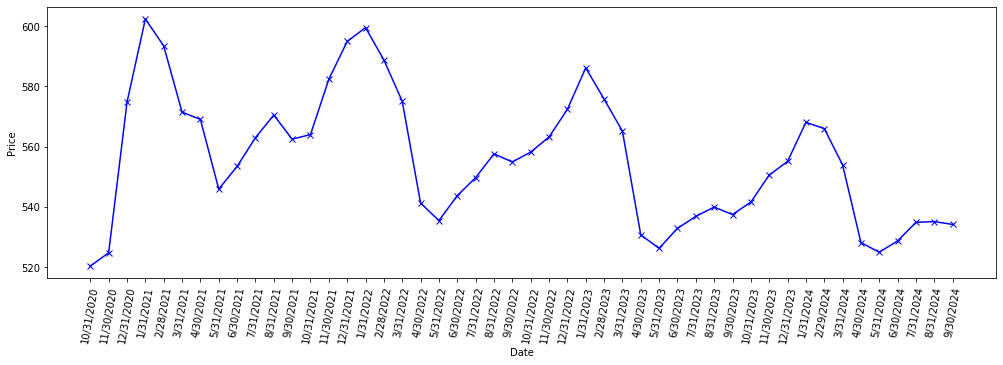

In [6]:
plt.figure(figsize=(17, 5))
plt.plot(data['Date'],data['Price'], 'b-x')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=80)
plt.show()

In [7]:
data['Date'] = data.apply(lambda row: datetime.strptime(row['Date'], "%m/%d/%Y"), axis=1)

In [8]:
min_date = min(data['Date'])
data['Time'] = (data['Date']-min(data['Date']))
data['Time'] = data.apply(lambda row: row['Time'].days, axis=1)

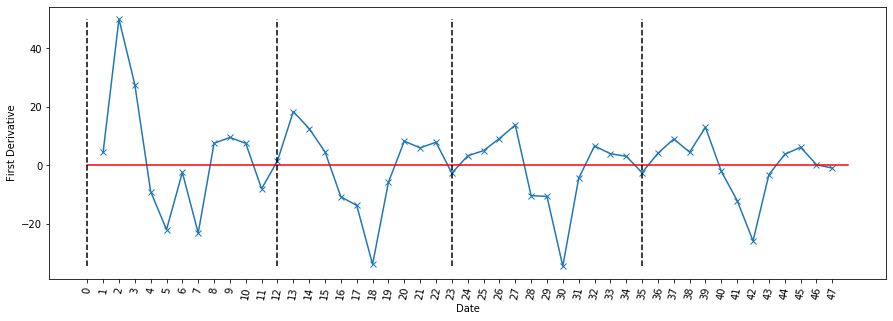

In [16]:
data_diff = data['Price'].diff(1)
plt.figure(figsize=(15, 5))
anchors = [0, 12, 23, 35]
plt.plot(data_diff, 'x-')
plt.plot([0, len(data)], [0, 0], 'r')
for anchor in anchors:
    plt.plot([anchor, anchor], [np.nanmin(data_diff), np.nanmax(data_diff)], 'k--')
plt.xticks(range(len(data)))
plt.xlabel('Date')
plt.ylabel('First Derivative')
plt.xticks(rotation=80)
plt.show()

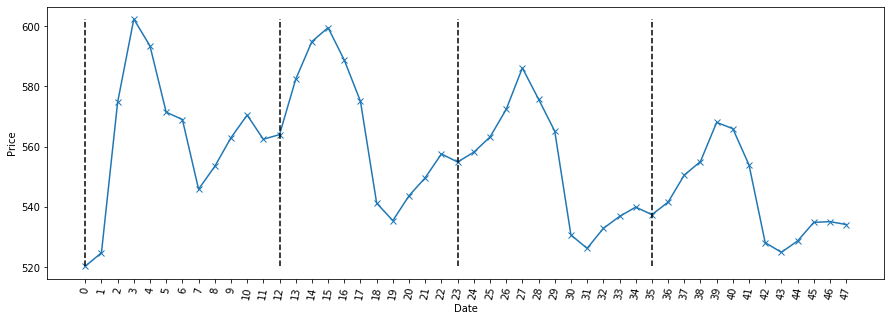

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(data['Price'], 'x-')
plt.xticks(range(len(data)))
for anchor in anchors:
    plt.plot([anchor, anchor], [min(data['Price']), max(data['Price'])], 'k--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=80)
plt.show()

### Extrapolation-Interpolation Method

In [59]:
# Grouping

i = anchors[0]
Y = []
Y_dates = []
Y_times = []
while i<11:
    row = [data['Price'][i+anchors[j]] for j in range(len(anchors))]
    date_row = [data['Date'][i+anchors[j]] for j in range(len(anchors))]
    time_row = [data['Time'][i+anchors[j]] for j in range(len(anchors))]
    Y.append(row)
    Y_dates.append(date_row)
    Y_times.append(time_row)
    i += 1

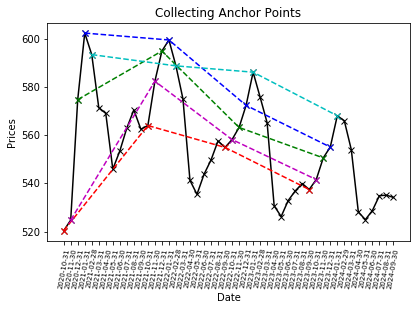

In [60]:
# Plotting groups

colors = ['r', 'm', 'g', 'b', 'c']
anchors = [0, 12, 23, 35]
plt.figure(figsize=(6.5, 4))
plt.title('Collecting Anchor Points')
plt.plot(data['Price'], 'kx-')
for i in range(len(colors)):
    try:
        plt.plot([j+i for j in anchors], [data['Price'][j+i] for j in anchors], colors[i]+'x--')
    except:
        plt.plot([j+i for j in anchors], [data['Price'][j+i] for j in anchors], 'x--')
plt.xticks(range(len(data['Date'])), list(map(lambda x: datetime.strftime(x, '%Y-%m-%d'), data['Date'])), rotation=80, fontsize=7)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.show()

#### Extrapolation

In [65]:
k_max = 2

f1d = []
for i in range(len(Y)):
    f = interp1d(Y_times[i], Y[i], fill_value="extrapolate", kind='linear')
    f1d.append(f)
dummy_times = [(max(Y_dates[i]) + timedelta(days=365*k) - min_date).days for i in range(len(Y)) for k in range(1, k_max)]
dummy_Y = [float(f1d[i](dummy_times[i*(k_max-1)+k-1])) for i in range(len(Y)) for k in range(1, k_max)]

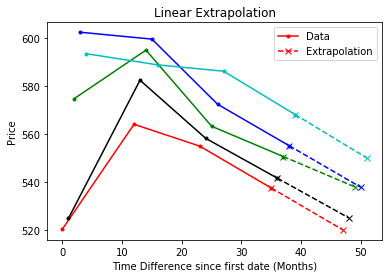

In [66]:
colors = ['r', 'k', 'g', 'b', 'c']
for i in range(len(colors)):
    plt.plot([j+i for j in anchors], [data['Price'][j+i] for j in anchors], colors[i]+'.-')
    plt.plot([anchors[-1]+i]+[anchors[-1]+12*k+i for k in range(1, k_max)], [data['Price'][anchors[-1]+i]]+[dummy_Y[i*(k_max-1)+k-1] for k in range(1, k_max)], colors[i]+'x--')
plt.legend(['Data', 'Extrapolation'])
plt.xlabel('Time Difference since first date (Months)')
plt.ylabel('Price')
plt.title('Linear Extrapolation')
plt.show()

#### Interpolation

In [67]:
superX = np.array(list(data['Time']) + dummy_times)
inds = np.argsort(superX)
superY = np.array(list(data['Price']) + dummy_Y)
superX = superX[inds]
superY = superY[inds]
cubicfn = CubicSpline(superX, superY)

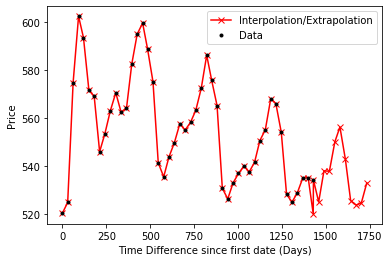

In [68]:
plt.plot(superX, superY, 'rx-')
plt.plot(data['Time'], data['Price'], 'k.')
plt.legend(['Interpolation/Extrapolation', 'Data'])
plt.xlabel('Time Difference since first date (Days)')
plt.ylabel('Price')
plt.show()

#### Quadratic Extrpolation

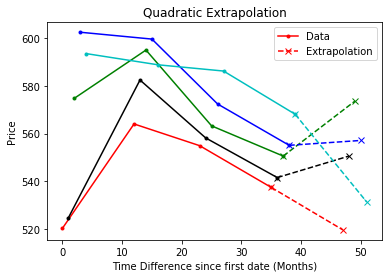

In [71]:
f1d = []
for i in range(len(Y)):
    f = interp1d(Y_times[i], Y[i], fill_value="extrapolate", kind='quadratic')
    f1d.append(f)
dummy_times = [(max(Y_dates[i]) + timedelta(days=365*k) - min_date).days for i in range(len(Y)) for k in range(1, k_max)]
dummy_Y = [float(f1d[i](dummy_times[i*(k_max-1)+k-1])) for i in range(len(Y)) for k in range(1, k_max)]

colors = ['r', 'k', 'g', 'b', 'c']
for i in range(len(colors)):
    plt.plot([j+i for j in anchors], [data['Price'][j+i] for j in anchors], colors[i]+'.-')
    plt.plot([anchors[-1]+i]+[anchors[-1]+12*k+i for k in range(1, k_max)], [data['Price'][anchors[-1]+i]]+[dummy_Y[i*(k_max-1)+k-1] for k in range(1, k_max)], colors[i]+'x--')
plt.legend(['Data', 'Extrapolation'])
plt.xlabel('Time Difference since first date (Months)')
plt.ylabel('Price')
plt.title('Quadratic Extrapolation')
plt.show()

#### Interpolation when Extrapolation was Quadratic

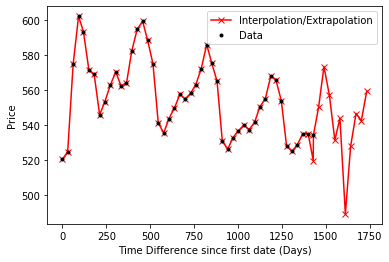

In [72]:
superX = np.array(list(data['Time']) + dummy_times)
inds = np.argsort(superX)
superY = np.array(list(data['Price']) + dummy_Y)
superX = superX[inds]
superY = superY[inds]
cubicfn = CubicSpline(superX, superY)

plt.plot(superX, superY, 'rx-')
plt.plot(data['Time'], data['Price'], 'k.')
plt.legend(['Interpolation/Extrapolation', 'Data'])
plt.xlabel('Time Difference since first date (Days)')
plt.ylabel('Price')
plt.show()

### Longer Times

In [73]:
k_max = 6

f1d = []
for i in range(len(Y)):
    f = interp1d(Y_times[i], Y[i], fill_value="extrapolate", kind='linear')
    f1d.append(f)
dummy_times = [(max(Y_dates[i]) + timedelta(days=365*k) - min_date).days for i in range(len(Y)) for k in range(1, k_max)]
dummy_Y = [float(f1d[i](dummy_times[i*(k_max-1)+k-1])) for i in range(len(Y)) for k in range(1, k_max)]

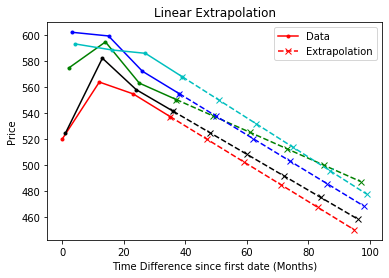

In [74]:
colors = ['r', 'k', 'g', 'b', 'c']
for i in range(len(colors)):
    plt.plot([j+i for j in anchors], [data['Price'][j+i] for j in anchors], colors[i]+'.-')
    plt.plot([anchors[-1]+i]+[anchors[-1]+12*k+i for k in range(1, k_max)], [data['Price'][anchors[-1]+i]]+[dummy_Y[i*(k_max-1)+k-1] for k in range(1, k_max)], colors[i]+'x--')
plt.legend(['Data', 'Extrapolation'])
plt.xlabel('Time Difference since first date (Months)')
plt.ylabel('Price')
plt.title('Linear Extrapolation')
plt.show()

#### Interpolation

In [75]:
superX = np.array(list(data['Time']) + dummy_times)
inds = np.argsort(superX)
superY = np.array(list(data['Price']) + dummy_Y)
superX = superX[inds]
superY = superY[inds]
cubicfn = CubicSpline(superX, superY)

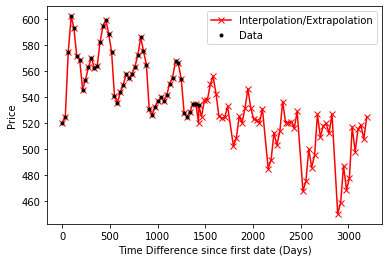

In [76]:
plt.plot(superX, superY, 'rx-')
plt.plot(data['Time'], data['Price'], 'k.')
plt.legend(['Interpolation/Extrapolation', 'Data'])
plt.xlabel('Time Difference since first date (Days)')
plt.ylabel('Price')
plt.show()

#### Quadratic Extrpolation

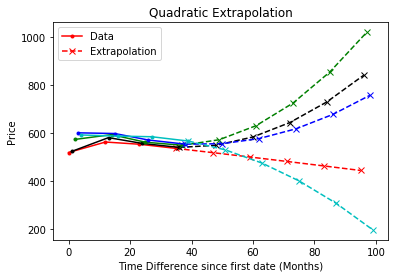

In [77]:
f1d = []
for i in range(len(Y)):
    f = interp1d(Y_times[i], Y[i], fill_value="extrapolate", kind='quadratic')
    f1d.append(f)
dummy_times = [(max(Y_dates[i]) + timedelta(days=365*k) - min_date).days for i in range(len(Y)) for k in range(1, k_max)]
dummy_Y = [float(f1d[i](dummy_times[i*(k_max-1)+k-1])) for i in range(len(Y)) for k in range(1, k_max)]

colors = ['r', 'k', 'g', 'b', 'c']
for i in range(len(colors)):
    plt.plot([j+i for j in anchors], [data['Price'][j+i] for j in anchors], colors[i]+'.-')
    plt.plot([anchors[-1]+i]+[anchors[-1]+12*k+i for k in range(1, k_max)], [data['Price'][anchors[-1]+i]]+[dummy_Y[i*(k_max-1)+k-1] for k in range(1, k_max)], colors[i]+'x--')
plt.legend(['Data', 'Extrapolation'])
plt.xlabel('Time Difference since first date (Months)')
plt.ylabel('Price')
plt.title('Quadratic Extrapolation')
plt.show()

#### Interpolation when Extrapolation was Quadratic

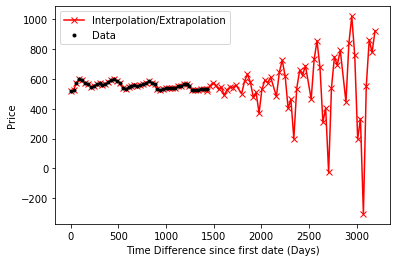

In [78]:
superX = np.array(list(data['Time']) + dummy_times)
inds = np.argsort(superX)
superY = np.array(list(data['Price']) + dummy_Y)
superX = superX[inds]
superY = superY[inds]
cubicfn = CubicSpline(superX, superY)

plt.plot(superX, superY, 'rx-')
plt.plot(data['Time'], data['Price'], 'k.')
plt.legend(['Interpolation/Extrapolation', 'Data'])
plt.xlabel('Time Difference since first date (Days)')
plt.ylabel('Price')
plt.show()

### Time Series Model

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

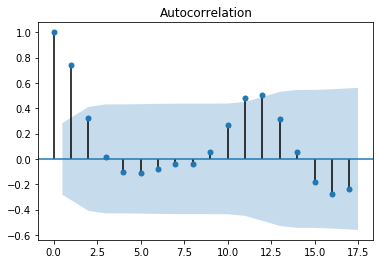

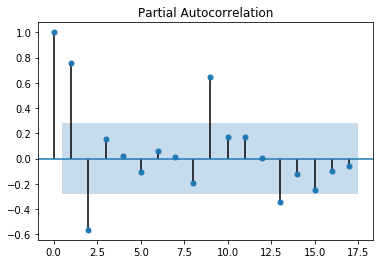

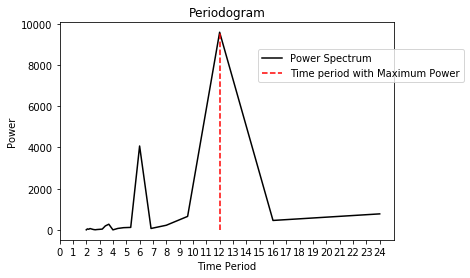

In [47]:
plot_acf(data['Price'])
plt.show()

plot_pacf(data['Price'])
plt.show()

f, Pxx = periodogram(data['Price'])
plt.figure()
plt.xlabel('Time Period')
plt.ylabel('Power')
plt.title('Periodogram')
plt.plot(1/f[2:], Pxx[2:], 'k-')
plt.plot([12, 12], [min(Pxx), max(Pxx)], 'r--')
plt.xticks(range(25), range(25))
plt.legend(['Power Spectrum', 'Time period with Maximum Power'], loc="upper center", bbox_to_anchor=(0.9, 0.9))
plt.show()

In [44]:
results= []
import warnings
warnings.filterwarnings('error')
for d in range(2):
    for q in range(3):
        for P in range(3):
            for Q in range(3):
                try:
                    model = SARIMAX(data['Price'], order=(0, d, q), seasonal_order=(P, 1, Q, 12)).fit(disp=-1)
                    aic = model.aic
                    print((0, d, q, P, 1, Q), aic)
                    results.append([(0, d, q, P, 1, Q), aic])
                except:
                    pass

results = np.array(results)
print('Best Model =', results[np.argmin(results[:, 1]), 0])

(0, 0, 0, 0, 1, 0) 309.64294543376656
(0, 0, 0, 1, 1, 0) 311.3423957766591
(0, 0, 0, 2, 1, 0) 311.41315693902766
(0, 0, 1, 0, 1, 0) 288.95562290074287
(0, 0, 1, 1, 1, 0) 290.6764405828011
(0, 0, 1, 2, 1, 0) 291.3424644388552
(0, 0, 2, 0, 1, 0) 281.54236127949605
(0, 0, 2, 1, 1, 0) 283.5345139869524
(0, 0, 2, 2, 1, 0) 284.8774672337437
(0, 1, 0, 0, 1, 0) 267.62341507138433
(0, 1, 0, 1, 1, 0) 269.350385032439
(0, 1, 0, 2, 1, 0) 271.3390427804988
(0, 1, 1, 0, 1, 0) 269.0343087659223
(0, 1, 1, 1, 1, 0) 270.800682739907
(0, 1, 1, 2, 1, 0) 272.7851014832589
(0, 1, 2, 0, 1, 0) 270.79498662874767
(0, 1, 2, 1, 1, 0) 272.614318737359
(0, 1, 2, 2, 1, 0) 274.57355617975884
Best Model = (0, 1, 0, 0, 1, 0)


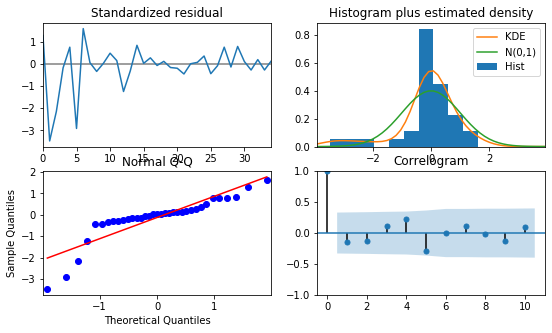

In [45]:
model = SARIMAX(data['Price'], order=(0, 1, 0), seasonal_order=(0, 1, 0, 12)).fit(disp=-1)
model.plot_diagnostics(figsize=(9, 5))
plt.show()

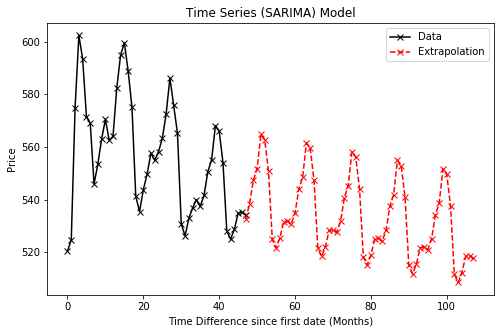

In [46]:
forecast = model.predict(start=len(data)-1, end=len(data) + 59)
plt.figure(figsize=(8, 5))
plt.plot(data['Price'], 'kx-')
plt.plot(range(len(data)-1, len(data)+60), forecast, 'rx--')
plt.legend(['Data', 'Extrapolation'])
plt.xlabel('Time Difference since first date (Months)')
plt.ylabel('Price')
plt.title('Time Series (SARIMA) Model')
plt.show()
plt.show()

## Question 4

In [85]:
L = 4
T_is = ['2020-11-1', '2020-12-1', '2021-1-1', '2021-2-1'] 
F_is = [2.645, 1.992, 4.25, 1.916]
G = 6         # Injection/withdraw rate
H = 0.00052   # Storage cost per day per unit
I = 30        # Maximum storage
J = 0.00008   # Penalty per day per unit

### Recursive Algorithm

In [81]:
choices = ['Sell', 'Buy', 'Do Nothing']

def valueRec(i, storage, dates, prices, G, H, I, J, L):
    
    add = 0
    
    if i == L:
        return add, []
    
    if i > 0:
        add -= storage*H*(dates[i] - dates[i-1]).days
        
    if storage > I:
        add -= (storage-I)*J*(dates[i] - dates[i-1]).days
    
    fut_val2, decision2 = valueRec(i+1, storage+G, dates, prices, G, H, I, J, L)
    opt2 = -prices[i]*G + fut_val2
    
    fut_val3, decision3 = valueRec(i+1, storage, dates, prices, G, H, I, J, L)
    opt3 = fut_val3
    
    if storage >= G:    
        fut_val1, decision1 = valueRec(i+1, storage-G, dates, prices, G, H, I, J, L)
        opt1 = prices[i]*G + fut_val1
        opts = [opt1, opt2, opt3]
        decisions = [decision1, decision2, decision3]
        ind = np.argmax(opts)
        val = add + opts[ind]
        print([ (add + opts[j], [choices[j]] + decisions[j]) for j in range(3) ])
    
    else:
        opts = [opt2, opt3]
        ind = np.argmax(opts) + 1
        val = add + opts[ind-1]
        decisions = [decision2, decision3]
        print([ (add + opts[j], [choices[j+1]] + decisions[j]) for j in range(2)])
    
    choice = choices[ind]
    future_decision = eval('decision' + str(ind+1))
    
    decision = [choice] + future_decision 
    return val, decision

### Dynamic Programing Solution

In [82]:
def valueDP(L, T_is, F_is, G, H, I, J, plots=False):
    
    days = list(map(lambda date: datetime.strptime(date, "%Y-%m-%d"), T_is))
    
    dp_loc = -1*np.ones([L+1, L+1])
    
    min_num = -2e132
    dp = min_num*np.ones([L+1, L+1])
    dp[0][0] = 0

    for j in range(1, L+1):
        for i in range(j+1):
                
            if j==L:

                if i<j-1:
                    sell = dp[i+1][j-1] + G*F_is[j-1]
                else:
                    sell = min_num

                if i<j:
                    nothing = dp[i][j-1]
                else:
                    nothing = min_num
                
                options = [sell, nothing]
                option_locs = [i+1, i]
                ind = np.argmax(options)
                dp[i][j] = options[ind]
                dp_loc[i][j] = option_locs[ind]

            else:
                
                storage = (days[j] - days[j-1]).days*i*G*H
                
                # Buy
                if i>0:
                    buy = dp[i-1][j-1] - storage - G*F_is[j-1]
                    if i*G > I:
                        buy -= (i*G - I)*J*(days[j] - days[j-1]).days
                else:
                    buy = min_num

                # Sell
                if i<j-1:
                    sell = dp[i+1][j-1] - storage + G*F_is[j-1]
                    if i*G > I:
                        sell -= (i*G - I)*J*(days[j] - days[j-1]).days
                else:
                    sell = min_num

                # Do Nothing
                if i<j:
                    nothing = dp[i][j-1] - storage
                    if i*G > I:
                        nothing -= (i*G - I)*J*(days[j] - days[j-1]).days
                else:
                    nothing = min_num
            
                options = [buy, sell, nothing]
                option_locs = [i-1, i+1, i]
                ind = np.argmax(options)
                dp[i][j] = options[ind]
                dp_loc[i][j] = option_locs[ind]

    ind = np.argmax(dp[:, -1])
    value = dp[ind][-1]
    vol = [ind*G]
    
    for i in range(L, 0, -1):
        ind = int(dp_loc[ind][i])
        vol = [ind*G] + vol
    
    if plots == True:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7), sharex=True)
        ax1.step(range(len(vol)), vol, 'k-')
        ax1.plot([0, len(vol)], [I, I], 'b--')
        ax1.legend(['Volume in Storage', 'Maximum Storage'])

        ax2.plot(range(len(F_is)), F_is, 'r-x')

        plt.xticks(range(len(vol)), list(map(lambda day: datetime.strftime(day, '%Y-%m-%d'), days)), rotation=80)
        plt.xlabel('Date')
        ax1.set_ylabel('Volume')
        ax2.set_ylabel('Price')

        plt.tight_layout()
        plt.savefig('plots\\AlgorithmRun.png', format='png')
        plt.show()

    return value, dp, vol

### Test Data

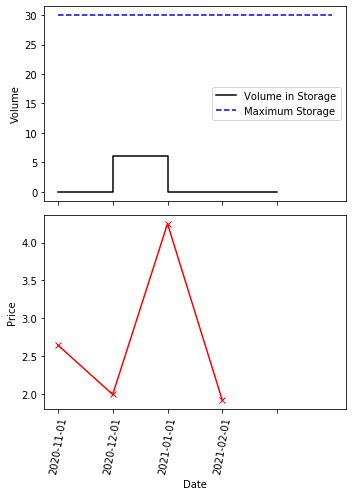

Final Value: 13.45128


In [86]:
val, dp, vol = valueDP(L, T_is, F_is, G, H, I, J, plots=True)
print('Final Value:', val)

### Dummy Data

In [89]:
L = 20
T_is = ['2020-11-1', '2020-12-1', '2021-1-1', '2021-2-1', '2021-3-1', '2021-4-1', '2021-5-1', '2021-6-1', '2021-7-1', '2021-8-1', '2021-9-1', '2021-10-1', '2021-11-1', '2021-12-1', '2022-1-1', '2022-2-1', '2022-3-1', '2022-4-1', '2022-5-1', '2022-6-1'] 
F_is = np.random.uniform(0, 10, 20)
G = int(np.random.uniform(10, 100))
H = np.random.uniform(0, 0.001)
I = int(np.random.uniform(50, 200))
J = np.random.uniform(0, 0.001)

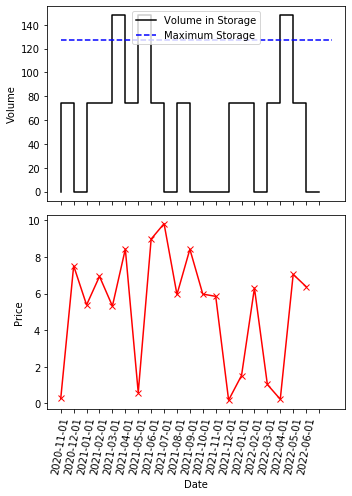

Final Value: 3221.1407004665175


In [90]:
val, dp, vol = valueDP(L, T_is, F_is, G, H, I, J, plots=True)
print('Final Value:', val)

In [91]:
buyInd = []
sellInd = []
for i in range(1, len(vol)):
    if vol[i]>vol[i-1]:
        buyInd.append(i-1)
    elif vol[i]<vol[i-1]:
        sellInd.append(i-1)

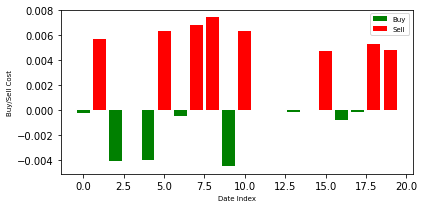

In [93]:
plt.figure(figsize=(6, 3))
plt.bar(buyInd, -H*F_is[buyInd], color='green')
plt.bar(sellInd, H*F_is[sellInd], color='red')
plt.legend(['Buy', 'Sell'], fontsize=7)
plt.xlabel('Date Index', fontsize=7)
plt.ylabel('Buy/Sell Cost', fontsize=7)
plt.tight_layout()
plt.savefig('plots//buysell.png', format='png')
plt.show()

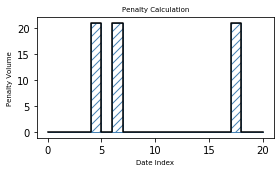

In [95]:
volE = np.array(vol)
volE[volE<I]=0
volE[volE>=I]=volE[volE>=I]-I

plt.figure(figsize=(4, 2.5))
plt.step(range(len(volE)), volE, 'k-')
plt.xlabel('Date Index', fontsize=7)
plt.ylabel('Penalty Volume', fontsize=7)
plt.title('Penalty Calculation', fontsize=7)
plt.fill_between(range(len(volE)), volE, step='pre', hatch='///', facecolor = 'none', edgecolor='steelblue')
plt.tight_layout()
plt.savefig('plots\\penalty.png', format='png')
plt.show()

### Effect of Parameters

In [96]:
L = 4
T_is = ['2020-11-1', '2020-12-1', '2021-1-1', '2021-2-1'] 
F_is = [2.645, 1.992, 4.25, 1.916]
# G = 6         # Injection/withdraw rate
# H = 0.00052   # Storage cost per day per unit
# I = 30        # Maximum storage
# J = 0.00008   # Penalty per day per unit

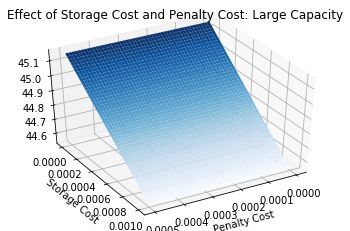

In [99]:
from mpl_toolkits.mplot3d import Axes3D

H_range = np.linspace(0, 0.001, 50)
J_range = np.linspace(0, 0.0005, 50)

I = 30
G = 20

vals = []
for H in H_range:
    for J in J_range:
        val, _, _ = valueDP(L, T_is, F_is, G, H, I, J)
        vals.append(val)

X, Y = np.meshgrid(J_range, H_range)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(vals).reshape(len(H_range),len(J_range)), cmap='Blues')
ax.view_init(40, 60)
ax.set_xlabel('Penalty Cost')
ax.set_ylabel('Storage Cost')
plt.title('Effect of Storage Cost and Penalty Cost: Large Capacity')
plt.savefig('plots\\HJ_largeI.png', format='png')

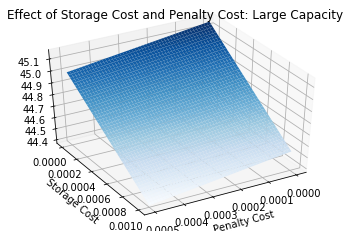

In [101]:
# from mpl_toolkits.mplot3d import Axes3D

H_range = np.linspace(0, 0.001, 50)
J_range = np.linspace(0, 0.0005, 50)

I = 10
G = 20

vals = []
for H in H_range:
    for J in J_range:
        val, _, _ = valueDP(L, T_is, F_is, G, H, I, J)
        vals.append(val)

X, Y = np.meshgrid(J_range, H_range)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(vals).reshape(len(H_range),len(J_range)), cmap='Blues')
ax.view_init(40, 60)
ax.set_xlabel('Penalty Cost')
ax.set_ylabel('Storage Cost')
plt.title('Effect of Storage Cost and Penalty Cost: Large Capacity')
plt.savefig('plots\\HJ_smallI.png', format='png')

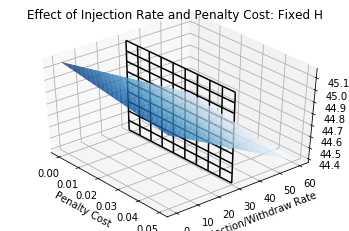

In [102]:
G_range = np.linspace(0, 60, 50)
J_range = np.linspace(0, 0.05, 50)

H = 0.00052
I = 30

# vals = []
# for G in G_range:
#     for J in J_range:
#         val, _ = valueDP(L, T_is, F_is, G, H, I, J)
#         vals.append(val)

X, Y = np.meshgrid(J_range, G_range)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(vals).reshape(len(G_range),len(J_range)), cmap='Blues')

J_range = np.linspace(-0.0005, 0.05, 10)
X, Y = np.meshgrid(J_range, I*np.ones(10))
Z = np.array(list(np.linspace(min(vals), max(vals), 10))*10).reshape(10, 10)
ax.plot_wireframe(X, Y, Z.T, color='black')

ax.view_init(40, 320)
ax.set_xlabel('Penalty Cost')
ax.set_ylabel('Injection/Withdraw Rate')
plt.title('Effect of Injection Rate and Penalty Cost: Fixed H')
plt.savefig('GJ_fixedH.png', format='png')

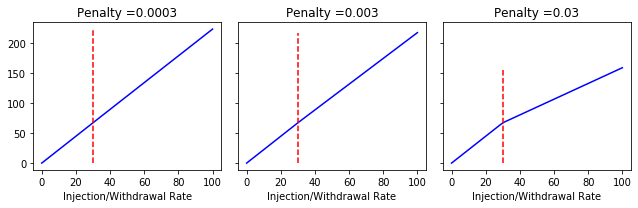

In [105]:
G_range = np.linspace(0, 100, 50)
H = 0.00052
I = 30

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(9, 3))

i = 0
for J in [0.0003, 0.003, 0.03]:
    vals = []
    for G in G_range:
        val, _, _ = valueDP(L, T_is, F_is, G, H, I, J)
        vals.append(val)

    ax[i].plot(G_range, vals, 'b-')
    ax[i].plot([I, I], [min(vals), max(vals)], 'r--')
    ax[i].set_xlabel('Injection/Withdrawal Rate')
    ax[i].set_title('Penalty =' + str(J))
    i += 1

plt.tight_layout()
plt.savefig('G_fixedI.png', format='png')
plt.show()

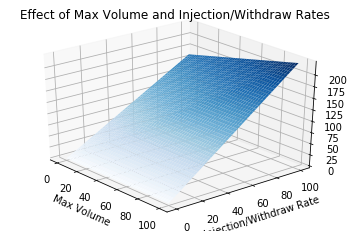

In [107]:
G_range = np.linspace(0, 100, 50)
I_range = np.linspace(0, 100, 50)

H = 0.00052
J = 0.02

vals = []
for G in G_range:
    for I in I_range:
        val, _, _ = valueDP(L, T_is, F_is, G, H, I, J)
        vals.append(val)

X, Y = np.meshgrid(I_range, G_range)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(vals).reshape(len(G_range),len(I_range)), cmap='Blues')
ax.set_xlabel('Max Volume')
ax.set_ylabel('Injection/Withdraw Rate')
ax.view_init(30, 320)
plt.title('Effect of Max Volume and Injection/Withdraw Rates')
plt.savefig('GI_highJ.png', format='png')
plt.show()

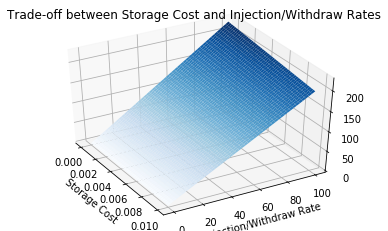

In [108]:
G_range = np.linspace(0, 100, 50)
H_range = np.linspace(0, 0.01, 50)

I = 30
J = 0.00008

vals = []
for G in G_range:
    for H in H_range:
        val, _, _ = valueDP(L, T_is, F_is, G, H, I, J)
        vals.append(val)

X, Y = np.meshgrid(H_range, G_range)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(vals).reshape(len(G_range),len(I_range)), cmap='Blues')
ax.set_xlabel('Storage Cost')
ax.set_ylabel('Injection/Withdraw Rate')
ax.view_init(40, 330)
plt.title('Trade-off between Storage Cost and Injection/Withdraw Rates')
plt.savefig('GH.png', format='png')

## Question 5

In [112]:
from math import exp, sqrt
N = 4
T_is = ['2020-11-1', '2020-12-1', '2021-1-1', '2021-2-1'] 
dates = list(map(lambda date: datetime.strptime(date, "%Y-%m-%d"), T_is))
mu = [2.645, -1.992, 4.25, -1.916]
H = 0.0052
sigma = 1.4
S0 = 2.2
m = 30000
maxVol = 32

### Monte Carlo

In [113]:
t0 = datetime.strptime('2020-09-27', "%Y-%m-%d")
w0 = np.zeros(m)

drift = 0
w_prev = w0
t_prev = t0
T = 0
S = []

for i in range(N):
    var = (dates[i]-t_prev).days/365
    t_prev = dates[i]
    T += var
    w = w_prev + np.random.normal(loc=0, scale=sqrt(var), size=m)
    w_prev = w
    drift += mu[i]*var
    factor = drift - (sigma**2)*T/2 + sigma*w
    S.append(S0*np.exp(factor))
S = np.array(S)
S_mean = np.mean(S, 1)

### Plotting Sample Paths

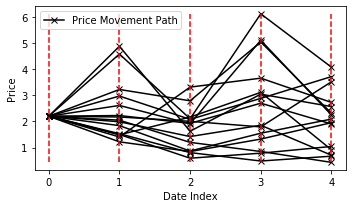

In [114]:
plt.figure(figsize=(5, 3))
for i in range(15):
    Sp = [S0] + list(S[:, i])
    plt.plot(Sp, 'kx-')
plt.legend(['Price Movement Path'])

for j in range(len(S)+1):
    plt.plot([j, j], [np.min(S[:, :15]), np.max(S[:, :15])], 'r--')

plt.xlabel('Date Index')
plt.xticks(range(len(S)+1), range(len(S)+1))
plt.ylabel('Price')
plt.tight_layout()
plt.savefig('plots\\movement.png', format='png')
plt.show()

In [115]:
print('Expected Prices =', S_mean)

Expected Prices = [2.83748836 2.40689823 3.47583258 2.96313353]


### Naive Method

In [116]:
def f1(S_mean):
    max_val = 0
    for start in range(len(dates)-1):
        for end in range(start+1, len(dates)):
            stoCost = H * (dates[end] - dates[start]).days
            value = S_mean[end]*maxVol - S_mean[start]*maxVol - stoCost
            if value > max_val:
                max_val = value
                loc1 = start
                loc2 = end

    return max_val

### Improved Method

In [117]:
def f2(S_mean):
    dp = np.zeros(len(S_mean)).astype(int)
    dp[0] = 0
    best_val = 0

    for i in range(1, len(S_mean)):
        val1 = (S_mean[i] - S_mean[i-1])*maxVol - H*(dates[i]-dates[i-1]).days
        val2 = (S_mean[i] - S_mean[dp[i-1]])*maxVol - H*(dates[i]-dates[dp[i-1]]).days
        if val1 < 0 and val2 < 0:
            dp[i] = i
            val = 0
        elif val1 > val2:
            dp[i] = i-1
            val = val1
        else:
            dp[i] = dp[i-1]
            val = val2

        if val > best_val:
            best_val = val
            loc1 = dp[i]
            loc2 = i

    return best_val

In [119]:
print('Value of Trade =', f1(S_mean))

Value of Trade = 34.04469899781528
